# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

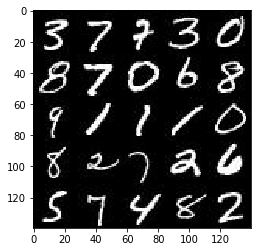

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*112, activation=None)
        
        x1 = tf.reshape(x1, [-1, 7, 7, 112])
        x1 = tf.contrib.layers.batch_norm(x1, is_training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.contrib.layers.batch_norm(x2, is_training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=128
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    # gen_samples = sess.run(generator(input_z, 3, training=False), feed_dict={input_z: sample_z})
                    # samples.append(gen_samples)
                    # _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    # plt.show()
                    n_images = 9
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1026... Generator Loss: 2.7539
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 2.8971
Epoch 1/2... Discriminator Loss: 0.0974... Generator Loss: 3.9046
Epoch 1/2... Discriminator Loss: 0.3004... Generator Loss: 2.2248
Epoch 1/2... Discriminator Loss: 0.2499... Generator Loss: 2.0556
Epoch 1/2... Discriminator Loss: 0.2916... Generator Loss: 2.0829
Epoch 1/2... Discriminator Loss: 0.2211... Generator Loss: 2.2641
Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 1.4021
Epoch 1/2... Discriminator Loss: 0.2286... Generator Loss: 2.8110
Epoch 1/2... Discriminator Loss: 0.3130... Generator Loss: 1.8406
Epoch 1/2... Discriminator Loss: 0.3657... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 2.2792


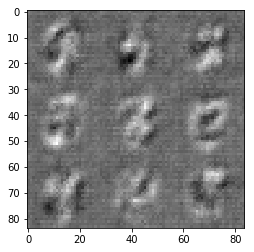

Epoch 1/2... Discriminator Loss: 2.0523... Generator Loss: 0.1809
Epoch 1/2... Discriminator Loss: 0.2618... Generator Loss: 2.3890
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.3767
Epoch 1/2... Discriminator Loss: 0.2620... Generator Loss: 2.3729
Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 1.6372
Epoch 1/2... Discriminator Loss: 0.2980... Generator Loss: 2.3191
Epoch 1/2... Discriminator Loss: 0.2746... Generator Loss: 2.1458
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 0.2922... Generator Loss: 1.9345
Epoch 1/2... Discriminator Loss: 0.2431... Generator Loss: 2.8285
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 5.5783
Epoch 1/2... Discriminator Loss: 0.2599... Generator Loss: 2.3018
Epoch 1/2... Discriminator Loss: 0.2708... Generator Loss: 2.2929


Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 4.5238
Epoch 1/2... Discriminator Loss: 0.2611... Generator Loss: 2.5356
Epoch 1/2... Discriminator Loss: 0.2420... Generator Loss: 2.2682
Epoch 1/2... Discriminator Loss: 0.3054... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 0.3790... Generator Loss: 3.5578
Epoch 1/2... Discriminator Loss: 0.2579... Generator Loss: 2.3822
Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 1.9579
Epoch 1/2... Discriminator Loss: 0.2056... Generator Loss: 2.4623
Epoch 1/2... Discriminator Loss: 0.2861... Generator Loss: 2.5699
Epoch 1/2... Discriminator Loss: 0.2145... Generator Loss: 2.2956
Epoch 1/2... Discriminator Loss: 0.2403... Generator Loss: 2.2687
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 4.0084
Epoch 1/2... Discriminator Loss: 0.2539... Generator Loss: 2.5506


Epoch 1/2... Discriminator Loss: 0.1804... Generator Loss: 2.6716
Epoch 1/2... Discriminator Loss: 0.1821... Generator Loss: 2.8064
Epoch 1/2... Discriminator Loss: 0.2071... Generator Loss: 2.5833
Epoch 1/2... Discriminator Loss: 0.1942... Generator Loss: 2.8789
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 5.2110
Epoch 1/2... Discriminator Loss: 0.2273... Generator Loss: 2.3249
Epoch 1/2... Discriminator Loss: 0.2371... Generator Loss: 2.9405
Epoch 1/2... Discriminator Loss: 0.2418... Generator Loss: 3.1579
Epoch 2/2... Discriminator Loss: 1.4901... Generator Loss: 0.3483
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 2.4585
Epoch 2/2... Discriminator Loss: 0.2386... Generator Loss: 2.2580
Epoch 2/2... Discriminator Loss: 0.2403... Generator Loss: 2.2886
Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 1.6316


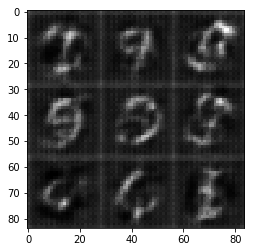

Epoch 2/2... Discriminator Loss: 0.2037... Generator Loss: 2.3267
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 6.0630
Epoch 2/2... Discriminator Loss: 0.2240... Generator Loss: 2.2874
Epoch 2/2... Discriminator Loss: 0.2127... Generator Loss: 2.5670
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.0771
Epoch 2/2... Discriminator Loss: 0.1585... Generator Loss: 3.2521
Epoch 2/2... Discriminator Loss: 0.2099... Generator Loss: 2.4828
Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 1.2698
Epoch 2/2... Discriminator Loss: 0.2421... Generator Loss: 3.6357
Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 2.2019
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.3886
Epoch 2/2... Discriminator Loss: 0.2246... Generator Loss: 2.3469


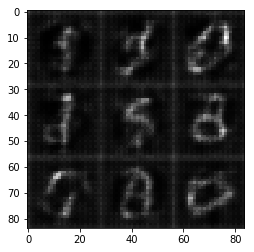

Epoch 2/2... Discriminator Loss: 0.3145... Generator Loss: 1.7200
Epoch 2/2... Discriminator Loss: 2.1963... Generator Loss: 0.2386
Epoch 2/2... Discriminator Loss: 0.4431... Generator Loss: 1.3731
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.1096
Epoch 2/2... Discriminator Loss: 0.3569... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: 0.2285... Generator Loss: 2.4121
Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 1.7534
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.6227
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 0.2779... Generator Loss: 2.1348
Epoch 2/2... Discriminator Loss: 0.2692... Generator Loss: 1.9087
Epoch 2/2... Discriminator Loss: 0.2843... Generator Loss: 1.9274


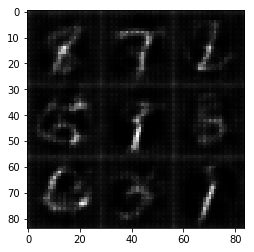

Epoch 2/2... Discriminator Loss: 0.2935... Generator Loss: 2.2129
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.4665
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 1.9569
Epoch 2/2... Discriminator Loss: 0.2575... Generator Loss: 2.1551
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 1.0712
Epoch 2/2... Discriminator Loss: 0.3496... Generator Loss: 1.6546
Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 1.7836
Epoch 2/2... Discriminator Loss: 0.2499... Generator Loss: 2.8710
Epoch 2/2... Discriminator Loss: 0.2942... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 2.4075
Epoch 2/2... Discriminator Loss: 0.2718... Generator Loss: 2.1095
Epoch 2/2... Discriminator Loss: 0.3181... Generator Loss: 1.8777
Epoch 2/2... Discriminator Loss: 0.3019... Generator Loss: 1.8655


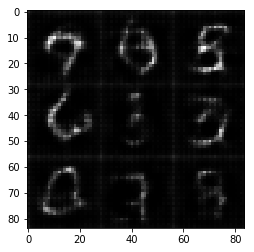

Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.2406
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 0.2205... Generator Loss: 2.1963


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1594... Generator Loss: 2.3719
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 2.7923
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.5124
Epoch 1/1... Discriminator Loss: 0.0690... Generator Loss: 3.3111
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 4.0977
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 3.8440
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.1987
Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 2.4471
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.9430


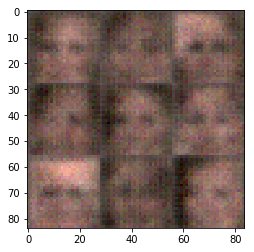

Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 2.4134
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 1.9497
Epoch 1/1... Discriminator Loss: 0.3037... Generator Loss: 3.3051
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 3.0722
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.2238
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 1.5735
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 0.2740... Generator Loss: 2.7353
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 2.0089... Generator Loss: 0.2012


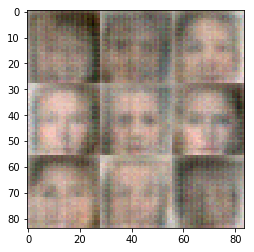

Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 2.1179
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 2.2438
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 1.4781
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 4.7840
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.2636... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.7706
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 2.2946
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.4024


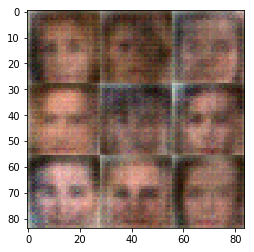

Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 3.0961
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 1.7806
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 2.0460
Epoch 1/1... Discriminator Loss: 2.1479... Generator Loss: 0.1719
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 2.3215
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 2.5429
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.8009


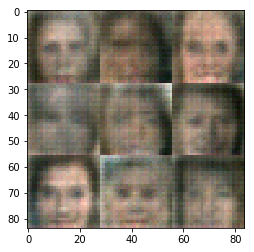

Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 1.7711
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.9150
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 2.7534
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.9855
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 3.1693
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.3636


Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.8923
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.6903


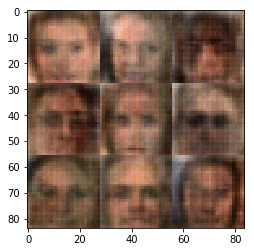

Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.7108
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.7434
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.7092
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.8040
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.6908


Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 2.8711
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.9961


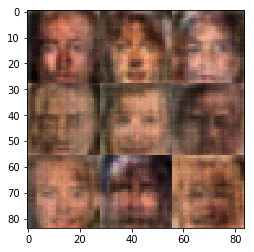

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 3.2582
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.2695
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 2.8025
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.7833


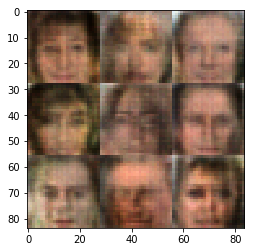

Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.8171
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 1.4624
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.6923


Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 1.5682
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 1.8854
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.2660


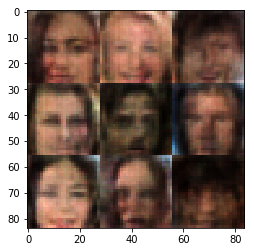

Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 2.6786
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.4280
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.4441
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 2.8689
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.3262


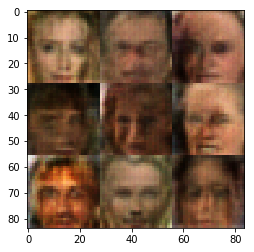

Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.9076
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 2.1589
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.0065


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.